In [1]:
import pandas as pd
import testing_scripts.constants as constants

# Section 1: Creating a labeled dataframe
This section involves reading in the resumes, filtering out entries whose CVs are too short, and creating positive and negative classes while filtering out all entries in neither class.

## From resumes parquet
This subsection assumes the existence of the resumes parquet file, processes, and exports the Labeled dataframe

In [24]:
# Read in the parquet
RESUMES_PARQUET_INPUT_FILENAME = "data/resumes.parquet"
raw_df = pd.read_parquet(RESUMES_PARQUET_INPUT_FILENAME, engine='pyarrow')  # raw dataframe

# Filter the dataframe by minimum cv length
MIN_CV_LENGTH = 500
filtered_df = raw_df.loc[raw_df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

# Add a true label column based on the specified keywords
import testing_scripts.label_resumes
testing_scripts.label_resumes.add_true_label_column(filtered_df, constants.POSITIVE_POSITION, constants.POSITIVE_KEYWORD, constants.NEGATIVE_POSITION, constants.NEGATIVE_KEYWORD)
labeled_df = filtered_df            # alias

# Filter out entries whose true label is NA (i.e. belongs to neither class)
labeled_df = labeled_df[labeled_df["True Label"].notna()]

# Export the labeled dataframe
LABELED_DATAFRAME_OUTPUT_FILENAME = "data/labeled_df.csv"
labeled_df.to_csv(LABELED_DATAFRAME_OUTPUT_FILENAME)

/Users/jasminepark/Documents/GitHub/llm-hiring-ecosystem/testing_scripts/label_resumes.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[TRUE_LABEL_COLUMN_NAME] = df.apply(label, axis = 1)


## From import
If the labeled_df.csv file already exists, run this instead to import the file

In [2]:
LABELED_DATAFRAME_INPUT_FILENAME = "data/labeled_df.csv"
labeled_df = pd.read_csv(LABELED_DATAFRAME_INPUT_FILENAME)

## True label playground
This subsection contains some light code for examining the true label

In [3]:
# The size of the positive and negative classes
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)

positiveClassSize = value_counts.get(constants.POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(constants.NEGATIVE_LABEL, default=0)
print(f"Proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

True Label
1    6753
0    6379
Name: count, dtype: int64
Proportion of positives = 0.5142400243679561


In [34]:
# Example positive entry
example_positive_entry = labeled_df.loc[labeled_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_cv: str = example_positive_entry.to_dict()["CV"]
print(f"Truncated positive CV:\n====================\n {example_positive_cv[:1000]}...")

Truncated positive CV:
 High levels of self-organization, structure, and attention to detail have helped build a successful career in advertising, as evidenced by hundreds of successfully completed projects, and train dozens of specialists. Previous experience is similar to project management methodologies used in the IT industry, including budgeting, planning, stakeholder management, risk mitigation, and effective communication. Creating new products inspires and motivates further development.
Account director
2018 - 2021
Management and development of client portfolio. 
Control over project development and progress. 
Planning and budgeting based on client portfolio. 
Analysis of project effectiveness and profitability. 
Operational management: organizing, coordinating, and controlling the work of the account team (planning and task allocation). 
Ensuring effective interaction of the account managers team between agency departments.

Senior account manager 
2017 - 2018
...munication wi

In [ ]:
# Example negative entry 
example_negative_entry = labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL].iloc[10]
exampleNegativeCV = example_negative_entry.to_dict()["CV"]
print(f"Truncated negative CV:\n====================\n {exampleNegativeCV[:1000]}")

# Section 2: Marking samples for Experiments
This section involves marking samples in the labeled dataframe for experiments. This allows us to experiment on a few samples at a time, rather than all entries at once.

## From labeled_df
This subsection assumes the existence of the labeled_df object within this notebook, processes, and exports the Marked dataframe

In [3]:
# How many samples from each class we want to mark for experiments
NUM_POSITIVE_SAMPLES = 300
NUM_NEGATIVE_SAMPLES = 300

# Create a new column "Marked for Experiments" and deterministically mark 
# the first NUM_POSITIVE_SAMPLES positive entries and the first NUM_NEGATIVE_SAMPLES negative entries True and all others false
labeled_df["Marked for Experiments"] = False
positive_sample_indices = labeled_df[labeled_df["True Label"] == constants.POSITIVE_LABEL].index[:NUM_POSITIVE_SAMPLES]
negative_sample_indices = labeled_df[labeled_df["True Label"] == constants.NEGATIVE_LABEL].index[:NUM_NEGATIVE_SAMPLES]
labeled_df.loc[positive_sample_indices, "Marked for Experiments"] = True
labeled_df.loc[negative_sample_indices, "Marked for Experiments"] = True
marked_df = labeled_df          # alias

# Export the marked dataframe
MARKED_DATAFRAME_OUTPUT_FILENAME = "data/marked_df_600.csv"
marked_df.to_csv(MARKED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the marked_df.csv file already exists, run this instead to import the file

In [4]:
MARKED_DATAFRAME_INPUT_FILENAME = "data/marked_df_600.csv"
marked_df = pd.read_csv(MARKED_DATAFRAME_INPUT_FILENAME)

## Mark playground
This subsection contains some light code for examining the true label

In [ ]:
# The total number of marked entries (should match NUM_POSITIVE_SAMPLES + NUM_NEGATIVE_SAMPLES)
value_counts = marked_df["Marked for Experiments"].value_counts()
print(f"Number of samples = {value_counts.get(True)}")

# Section 3: Generating tailored resumes
This section involves generating resumes tailored toward a specific job over the samples marked for experiments

## From marked_df
This subsection assumes the existence of the marked_df object within this notebook and generates modified resumes tailored toward the job specified in constants.py

In [5]:
# Add tailored resumes based on the job description using the chosen model
import testing_scripts.generate_resumes as generate_resumes
generate_resumes.create_modified_resumes(marked_df, job_name = constants.JOB_NAME, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME, verbose = True)
tailored_df = marked_df        # Alias

# Export the tailored dataframe
TAILORED_DATAFRAME_OUTPUT_FILENAME = "data/tailored_df_600.csv"
tailored_df.to_csv(TAILORED_DATAFRAME_OUTPUT_FILENAME)

Number of samples marked for experiments = 600
Generating a new tailored resume (0 generated so far)...
Generating a new tailored resume (1 generated so far)...
Generating a new tailored resume (2 generated so far)...
Generating a new tailored resume (3 generated so far)...
Generating a new tailored resume (4 generated so far)...
Generating a new tailored resume (5 generated so far)...
Generating a new tailored resume (6 generated so far)...
Generating a new tailored resume (7 generated so far)...
Generating a new tailored resume (8 generated so far)...
Generating a new tailored resume (9 generated so far)...
Generating a new tailored resume (10 generated so far)...
Generating a new tailored resume (11 generated so far)...
Generating a new tailored resume (12 generated so far)...
Generating a new tailored resume (13 generated so far)...
Generating a new tailored resume (14 generated so far)...
Generating a new tailored resume (15 generated so far)...
Generating a new tailored resume (1

## From import
If the tailored_df.csv file already exists, run this instead to import the file

In [22]:
TAILORED_DATAFRAME_INPUT_FILENAME = "data/tailored_df_600.csv"
tailored_df = pd.read_csv(TAILORED_DATAFRAME_INPUT_FILENAME)

## Tailored resumes playground
This subsection contains some light code for examining the tailored resumes

In [33]:
example_positive_entry = tailored_df[tailored_df["Marked for Experiments"] & tailored_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_CV = example_positive_entry["CV"]
example_positive_tailored_CV = example_positive_entry[constants.tailored_cv_name(model_name = constants.MODEL_NAME, job_name = constants.JOB_NAME)]

print(f"Truncated positive CV:\n====================\n {example_positive_CV[:750]}...")
print(f"\n\nTruncated positive tailored CV:\n====================\n {example_positive_tailored_CV[:750]}...")
# print(f"Example positive CV = {example_positive_cv}\n\n")

# example_tailored_positive_cv = generate_resumes.tailor_resume(example_positive_cv, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME)
# print(f"Example positive tailored CV = {example_tailored_positive_cv}")

Truncated positive CV:
 High levels of self-organization, structure, and attention to detail have helped build a successful career in advertising, as evidenced by hundreds of successfully completed projects, and train dozens of specialists. Previous experience is similar to project management methodologies used in the IT industry, including budgeting, planning, stakeholder management, risk mitigation, and effective communication. Creating new products inspires and motivates further development.
Account director
2018 - 2021
Management and development of client portfolio. 
Control over project development and progress. 
Planning and budgeting based on client portfolio. 
Analysis of project effectiveness and profitability. 
Operational management: organizing, c...


Truncated positive tailored CV:
  **Account Director**

* Managed and developed client portfolio, including control over project development and progress, planning and budgeting based on client portfolio, analysis of project e

# Section 4: Scoring resumes
This section involves scoring the original and generated CVs

## From tailored_df
This subsection assumes the existence of the tailored_df object within this notebook and computes for both the original and generated CVs

In [6]:
# Add scores for both the original and generated CVs
import testing_scripts.score_resumes as score_resumes
score_resumes.append_scores(tailored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = "CV", verbose = True)
score_resumes.append_scores(tailored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = constants.TAILORED_CV_NAME, verbose = True)
scored_df = tailored_df       # Alias

# Export the scored dataframe
SCORED_DATAFRAME_OUTPUT_FILENAME = "data/scored_df_600.csv"
scored_df.to_csv(SCORED_DATAFRAME_OUTPUT_FILENAME)

/Users/jasminepark/miniforge3/envs/hiring-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of samples marked for experiments = 600
Scoring a new resume (0 scored so far)...
Scoring a new resume (1 scored so far)...
Scoring a new resume (2 scored so far)...
Scoring a new resume (3 scored so far)...
Scoring a new resume (4 scored so far)...
Scoring a new resume (5 scored so far)...
Scoring a new resume (6 scored so far)...
Scoring a new resume (7 scored so far)...
Scoring a new resume (8 scored so far)...
Scoring a new resume (9 scored so far)...
Scoring a new resume (10 scored so far)...
Scoring a new resume (11 scored so far)...
Scoring a new resume (12 scored so far)...
Scoring a new resume (13 scored so far)...
Scoring a new resume (14 scored so far)...
Scoring a new resume (15 scored so far)...
Scoring a new resume (16 scored so far)...
Scoring a new resume (17 scored so far)...
Scoring a new resume (18 scored so far)...
Scoring a new resume (19 scored so far)...
Scoring a new resume (20 scored so far)...
Scoring a new resume (21 scored so far)...
Scoring a new res

## From import
If the scored_df.csv file already exists, run this instead to import the file

In [5]:
SCORED_DATAFRAME_INPUT_FILENAME = "data/scored_df_600.csv"
scored_df = pd.read_csv(SCORED_DATAFRAME_INPUT_FILENAME)

## Scored resumes playground
This subsection contains some light code for examining the resume scores

Slope: 0.36504377914807074
Intercept: 58.95379220528527
Coefficient of determination: 0.0863558826792431


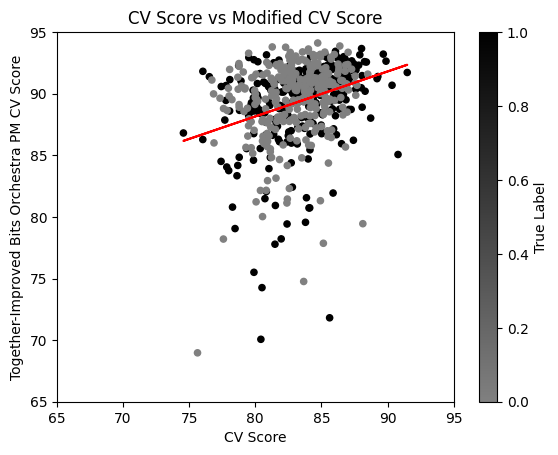

In [7]:
# Create a scatterplot of original score vs improved score
original_score_column_name = "CV Score"
modified_score_column_name = f"{constants.TAILORED_CV_NAME} Score"

all_scatterpoints: pd.DataFrame = scored_df.loc[scored_df["Marked for Experiments"], [original_score_column_name, modified_score_column_name, "True Label"]]

# Portray positive label as black and negative label as gray
from matplotlib.colors import LinearSegmentedColormap
POSITIVE_SCATTERPOINT_COLOR = "black"
NEGATIVE_SCATTERPOINT_COLOR = "gray"
positive_negative_colormap = LinearSegmentedColormap.from_list("Positive-Negative", [(constants.NEGATIVE_LABEL, NEGATIVE_SCATTERPOINT_COLOR), (constants.POSITIVE_LABEL, POSITIVE_SCATTERPOINT_COLOR)])

# Take nice square graph boundaries
x_min = all_scatterpoints[original_score_column_name].min()
x_max = all_scatterpoints[original_score_column_name].max()
y_min = all_scatterpoints[modified_score_column_name].min()
y_max = all_scatterpoints[modified_score_column_name].max()

import math
INCREMENT = 5
lower_boundary = math.floor( (min(x_min, y_min) - 0.1) / INCREMENT) * INCREMENT
upper_boundary = math.ceil( (max(x_max, y_max) + 0.1) / INCREMENT) * INCREMENT

score_scatterplot_axes = all_scatterpoints.plot.scatter(x = original_score_column_name, y = modified_score_column_name, 
                                                    c = "True Label", colormap = positive_negative_colormap,
                                                    title = "CV Score vs Modified CV Score",
                                                    xlim = (lower_boundary, upper_boundary), ylim = (lower_boundary, upper_boundary)
                                                    )

# Run linear regression on the combined 200 points
from sklearn.linear_model import LinearRegression
X = all_scatterpoints[[original_score_column_name]].values      # Reshaped into 2D array
y = all_scatterpoints[modified_score_column_name].values        # 1D array

linear_regression_model = LinearRegression()
linear_regression_model.fit(X, y)

# Get the coefficients
linear_regression_slope = linear_regression_model.coef_[0]
linear_regression_intercept = linear_regression_model.intercept_
linear_regression_coefficient_of_determination = linear_regression_model.score(X, y)

print(f"Slope: {linear_regression_slope}")
print(f"Intercept: {linear_regression_intercept}")
print(f"Coefficient of determination: {linear_regression_coefficient_of_determination}")

# Plot the combined plot
import matplotlib.pyplot as plt
predictions = linear_regression_model.predict(X)
score_scatterplot_axes.plot(X, predictions, color='red', label='Regression Line')

plt.show()